In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from meta_infomax.datasets.fudan_reviews import *
from meta_infomax.datasets import utils
from meta_infomax.models.sentiment_classifier import *
from meta_infomax.models.feed_forward import *

import numpy as np

from collections import Counter
import itertools

In [3]:
bert, tokenizer, _ = utils.get_transformer("bert-base-uncased")
ffn = FeedForward(768, 3, [512, 256, 2], nn.ReLU())
model = SentimentClassifier(bert, ffn)

datasets = MultiTaskDataset(tokenizer, split="all", validation_size=0).subset_datasets(domains=DATASETS)

# PMI Interesting words

In [206]:
from meta_infomax.trainers.PMIScorer import PMIScorer

scorer = PMIScorer(tokenizer, ["dvd"])

In [208]:
scorer.get_domain_PMIs("dvd_0")

OrderedDict([('farmhouse', 3.459568741939095),
             ('tom/joey', 3.459568741939095),
             ('motherly', 3.459568741939095),
             ('thora', 3.459568741939095),
             ('well-played', 3.459568741939095),
             ('blantantly', 3.459568741939095),
             ('sensically', 3.459568741939095),
             ("'hole", 3.459568741939095),
             ('rebuking', 3.459568741939095),
             ('zegers', 3.459568741939095),
             ('transamerica', 3.459568741939095),
             ('horseman', 3.459568741939095),
             ('growled', 3.459568741939095),
             ('a.e.w', 3.459568741939095),
             ('feversham', 3.459568741939095),
             ('resigns', 3.459568741939095),
             ('ethne', 3.459568741939095),
             ('durrance', 3.459568741939095),
             ('subverts', 3.459568741939095),
             ('`battle', 3.459568741939095),
             ('omdurman', 3.459568741939095),
             ('fatma', 3.4595687419390

# Data Statistics

In [157]:
avg_num_tokens = {ds_name: int(sum([len(ds[data_idx]['text'].split()) for data_idx in range(len(ds))]) / len(ds))
            for (ds_name, ds) in datasets.items()}

avg_num_tokens

{'apparel': 67,
 'baby': 119,
 'books': 183,
 'camera_photo': 138,
 'electronics': 117,
 'health_personal_care': 94,
 'imdb': 270,
 'kitchen_housewares': 98,
 'magazines': 127,
 'music': 149,
 'software': 149,
 'sports_outdoors': 106,
 'toys_games': 102,
 'video': 162,
 'MR': 21,
 'dvd': 196}

In [195]:
train_ds = MultiTaskDataset(tokenizer, validation_size=0.2)
valid_ds = MultiTaskDataset(tokenizer, split="val", validation_size=0.2)
test_ds = MultiTaskDataset(tokenizer, split="test", validation_size=0)

datasets_train_pos = train_ds.subset_datasets(domains=DATASETS, label=1)
datasets_train_neg = train_ds.subset_datasets(domains=DATASETS, label=0)

datasets_val_pos = valid_ds.subset_datasets(domains=DATASETS, label=1)
datasets_val_neg = valid_ds.subset_datasets(domains=DATASETS, label=0)

datasets_test_pos = test_ds.subset_datasets(domains=DATASETS, label=1)
datasets_test_neg = test_ds.subset_datasets(domains=DATASETS, label=0)

sizes = {ds_name: ((len(datasets_train_pos[ds_name]), len(datasets_train_neg[ds_name])),
                   (len(datasets_val_pos[ds_name]), len(datasets_val_neg[ds_name])),
                  (len(datasets_test_pos[ds_name]),len(datasets_test_neg[ds_name])))
        for ds_name in datasets}

In [196]:
df = pd.DataFrame(sizes).transpose()
df["Average Review Length"] = avg_num_tokens.values()

map_to_percentage = lambda x: f" {x[0]+x[1]} ({x[0]/(x[0]+x[1])*100:.0f}%)"
df[0] = df[0].apply(map_to_percentage)
df[1] = df[1].apply(map_to_percentage)
df[2] = df[2].apply(map_to_percentage)

df = df.rename(columns={0: "Train", 1:"Validation", 2:"Test"})
df.to_latex("sizes.txt")

# Domain shift

In [181]:
datasets = MultiTaskDataset(tokenizer, split="all", validation_size=0).subset_datasets(domains=DATASETS)

counters = {ds_name: Counter(
                        list(itertools.chain.from_iterable(
                            # it is a list of lists that needs to be flattened
                            [ds[data_idx]['text'].split() for data_idx in range(len(ds))]
                        ))) 
            for (ds_name, ds) in datasets.items()}

In [182]:
counters.keys()

dict_keys(['apparel', 'baby', 'books', 'camera_photo', 'electronics', 'health_personal_care', 'imdb', 'kitchen_housewares', 'magazines', 'music', 'software', 'sports_outdoors', 'toys_games', 'video', 'MR', 'dvd'])

In [183]:
def select_counters(counters, keys):
    return {k: v for k, v in counters.items() if k in keys}

def renyi(p_counter, q_counter, alpha=0.5):
    p_sum = sum(p_counter.values())
    q_sum = sum(q_counter.values())
    inner_sum = sum([pow(p_counter[word]/p_sum, 1-alpha) * pow(q_counter[word]/q_sum, alpha) for word in p_counter])
    return (1/(alpha - 1)) * np.log2(inner_sum)

def aggregated_renyi(p_counters, q_counter, alpha=0.5):
    renyi_values = []
    for p_counter in p_counters.values():
        renyi_values.append(renyi(p_counter, q_counter, alpha=alpha))
    return np.mean(renyi_values), np.std(renyi_values)

In [184]:
import itertools
from tqdm.notebook import tqdm

results_dict = {}
DATASETS = set(DATASETS)

for test_domains in tqdm(set(itertools.combinations(DATASETS, 1))):
    train_domains = DATASETS.difference(test_domains)
    
    domain_shift_train_test = [aggregated_renyi(select_counters(counters, train_domains), counters[test_dm])[0]
                                     for test_dm in test_domains]
    
    results_dict[test_domains[0]] = (np.mean(domain_shift_train_test), np.std(domain_shift_train_test))
    

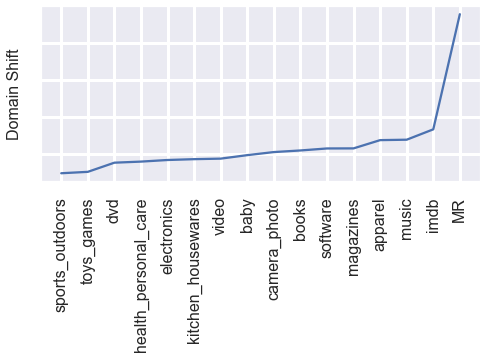

In [204]:
res_df = pd.DataFrame(results_dict).transpose().sort_values(by=0)
plt.style.use("seaborn-talk")

ax = res_df[0].plot(figsize=(7, 3))

xticks_list = list(res_df.index)
plt.xticks(rotation=90)
ax.set_xticks(range(len(xticks_list)))
ax.set_xticklabels(xticks_list, fontsize=16)

ax.set_yticklabels([])
ax.set_ylabel("Domain Shift", fontsize=16)

plt.grid(color='white', linewidth=3)
plt.savefig("domain_shift.pdf")

In [197]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

renyi_values = [[renyi(counter_1, counter_2) for counter_1 in counters.values()] 
                for counter_2 in counters.values()]
df_cm = pd.DataFrame(renyi_values, index = counters.keys(), columns = counters.keys())

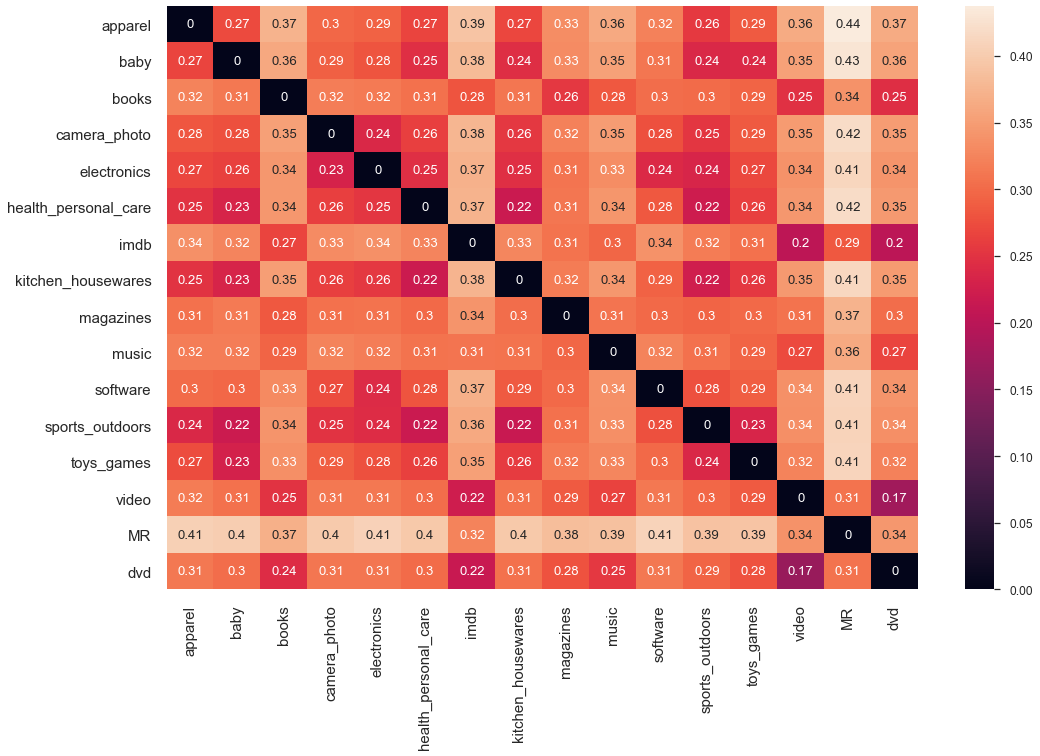

In [202]:
plt.figure(figsize = (15,10))
sn.set(font_scale=1.1)
hm = sn.heatmap(df_cm, annot=True)
hm.tick_params(labelsize=15)
fig = hm.get_figure()
fig.savefig("distance_heatmap.png")

In [199]:
from scipy.spatial.distance import jensenshannon

def get_jensenshannon(p_counter, q_counter):
    return jensenshannon([p_counter[key] for key in p_counter.keys()],
                         [q_counter[key] for key in p_counter.keys()])

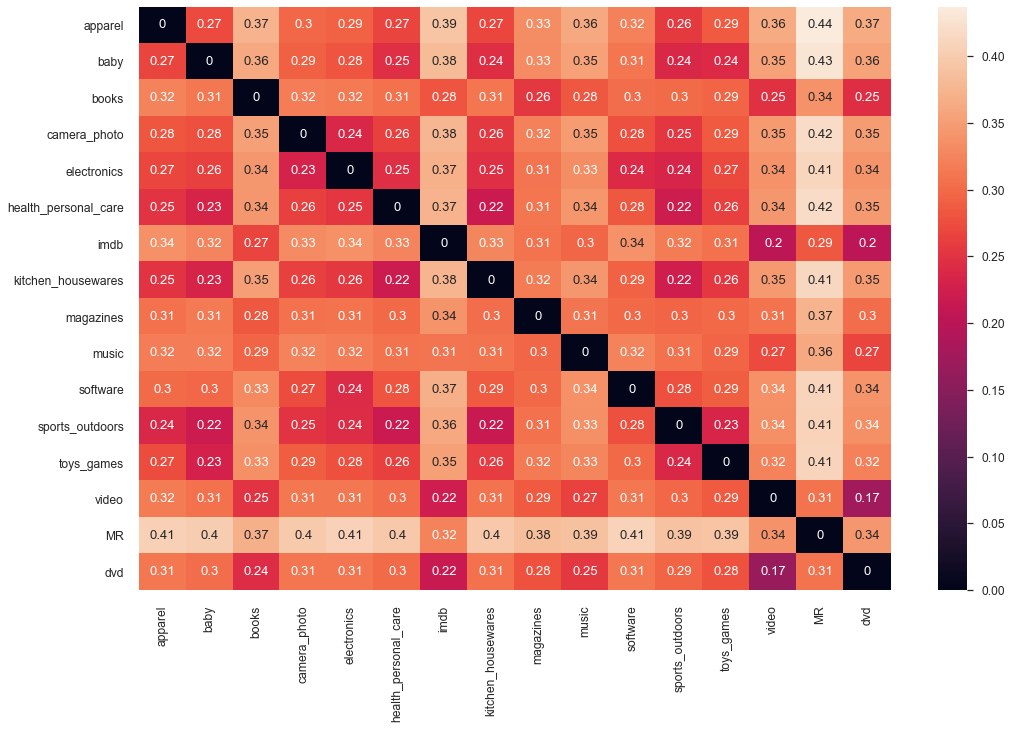

In [200]:
array = [[get_jensenshannon(counter_1, counter_2) for counter_1 in counters.values()] for counter_2 in counters.values()]

df_cm = pd.DataFrame(array, index = counters.keys(), columns = counters.keys())
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)